In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skfem import Basis, BilinearForm, ElementLineP1, LinearForm, MeshLine, enforce, solve
from skfem.helpers import dot, grad
from sklearn.gaussian_process.kernels import Matern

from ls_mcmc import model


class Forward_operator:
    def __init__(self, points_pde_solve: np.ndarray, points_observation: np.ndarray) -> None:
        self._points_observation = points_observation
        self._points = points_pde_solve
        N = self._points.shape[0]
        self._elements = np.vstack([np.arange(N - 1), np.arange(1, N)])
        self._mesh = MeshLine(self._points.reshape(1, -1), self._elements)
        self._basis = Basis(self._mesh, ElementLineP1())

    def _evaluate(self, state: np.ndarray) -> np.ndarray:
        def _A(x):
            flat = x.ravel()
            vals = np.interp(flat, self._points, state)
            return vals.reshape(x.shape)

        @BilinearForm
        def laplace(u, v, w):
            return _A(w.x[0]) * dot(grad(u), grad(v))

        @LinearForm
        def rhs(v, _):
            return 1.0 * v

        A = laplace.assemble(self._basis)
        b = rhs.assemble(self._basis)

        # Dirichlet boundary conditions
        A, b = enforce(A, b, D=self._mesh.boundary_nodes())

        # solve the linear system
        x = solve(A, b)
        return x

    def __call__(self, state: np.ndarray) -> np.ndarray:
        pde_sol = self._evaluate(state)
        observed = np.interp(self._points_observation, self._points, pde_sol)
        return observed


class PoissonModel(model.MCMCModel):
    def __init__(
        self, points: np.ndarray, G: Forward_operator, data: np.ndarray, noise_std: float
    ) -> None:
        N = points.shape[0]
        self._data = data
        self._G = G
        self._reference_point = np.zeros((N,))
        self._points = points
        self._noise_std = noise_std
        self._kernel = Matern(length_scale=0.3, nu=2)
        self._covariance = self._kernel(self._points.reshape(-1, 1)) + 1e-10 * np.eye(N)  # spd
        self._preconditioner_sqrt_matrix = np.linalg.cholesky(self._covariance)

    def evaluate_potential(self, state: np.ndarray) -> float:
        potential = (
            1 / 2 * np.linalg.norm((self._G(np.exp(state)) - self._data) / self._noise_std) ** 2
        )
        return potential

    def compute_preconditioner_sqrt_action(self, state: np.ndarray) -> np.ndarray:
        action = self._preconditioner_sqrt_matrix @ state
        return action

    @property
    def reference_point(self) -> np.ndarray:
        return self._reference_point

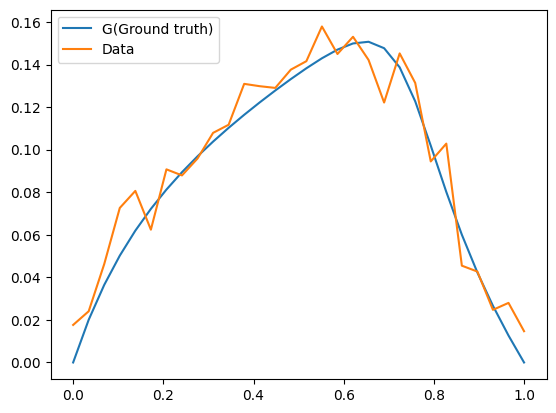

In [14]:
def coef(x: np.ndarray) -> np.ndarray:
    return 1.0 + 0.8 * np.sin(2 * np.pi * x)


np.random.seed(0)
N_pde = 500
N_obs = 30
points = np.linspace(0, 1, N_pde)
observation_points = np.linspace(0, 1, N_obs)
delta = 0.01
ground_truth = coef(points)
G = Forward_operator(points, observation_points)
data = G(ground_truth) + np.random.normal(scale=delta, size=(N_obs,))

posterior_model = PoissonModel(points, G, data, delta)

plt.plot(observation_points, G(ground_truth), label="G(Ground truth)")
plt.plot(observation_points, data, label="Data")
plt.legend()
plt.show()

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from ls_mcmc import algorithms, logging, output, sampling, storage

acceptance_rate_output = output.Acceptance()
outputs = (acceptance_rate_output,)
logger_settings = logging.LoggerSettings()
sampler_settings = sampling.SamplerRunSettings(
    num_samples=50000,
    initial_state=np.zeros((N_pde,)),
    print_interval=1000,
    store_interval=1,
)

sample_storage = storage.NumpyStorage()
logger = logging.MCMCLogger(logger_settings)
algorithm = algorithms.pCNAlgorithm(posterior_model, step_width=0.001)
sampler = sampling.Sampler(algorithm, sample_storage, outputs, logger)
samples, outputs = sampler.run(sampler_settings)

| Iteration   | Time        | Acceptance  | 
-------------------------------------------
| 0.000e+00   | 4.466e-03   | 1.0         | 
-------------------------------------------
| 0.000e+00   | 4.466e-03   | 1.0         | 
| 1.000e+03   | 6.820e-01   | 0.4735      | 
| 2.000e+03   | 1.346e+00   | 0.4838      | 
| 3.000e+03   | 2.051e+00   | 0.4878      | 
| 4.000e+03   | 2.733e+00   | 0.4866      | 
| 5.000e+03   | 3.435e+00   | 0.4787      | 
| 6.000e+03   | 4.139e+00   | 0.4788      | 
| 7.000e+03   | 4.811e+00   | 0.4788      | 
| 8.000e+03   | 5.471e+00   | 0.4761      | 
| 9.000e+03   | 6.141e+00   | 0.4736      | 
| 1.000e+04   | 6.802e+00   | 0.472       | 
| 1.100e+04   | 7.463e+00   | 0.4715      | 
| 1.200e+04   | 8.158e+00   | 0.472       | 
| 1.300e+04   | 8.885e+00   | 0.4733      | 
| 1.400e+04   | 9.563e+00   | 0.4718      | 
| 1.500e+04   | 1.025e+01   | 0.4714      | 
| 1.600e+04   | 1.095e+01   | 0.4717      | 
| 1.700e+04   | 1.162e+01   | 0.4729      | 
| 1.800e+04 

In [16]:
sample_ignore_burn_in = samples.values[25000:]
sample_mean = sample_ignore_burn_in.mean(axis=0)

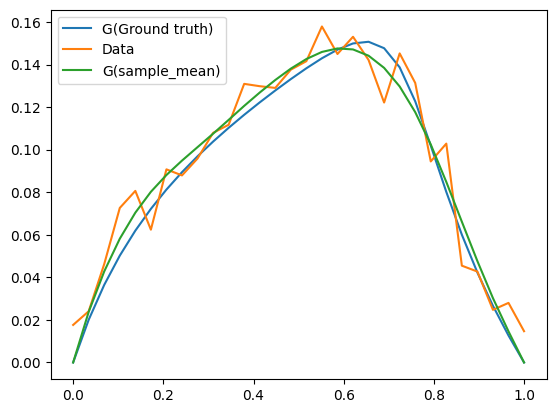

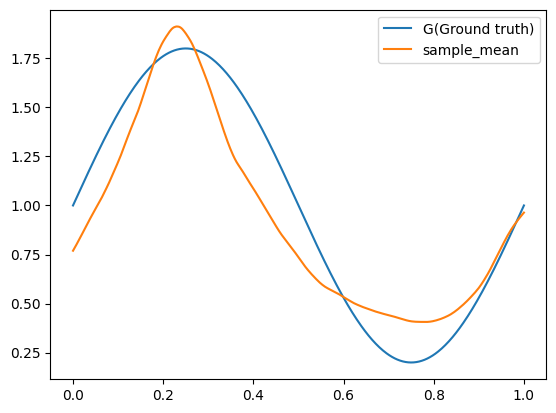

In [17]:
plt.plot(observation_points, G(ground_truth), label="G(Ground truth)")
plt.plot(observation_points, data, label="Data")
plt.plot(observation_points, G(np.exp(sample_mean)), label="G(sample_mean)")
plt.legend()
plt.show()
plt.plot(points, ground_truth, label="G(Ground truth)")
plt.plot(points, np.exp(sample_mean), label="sample_mean")
plt.legend()

In [18]:
# check mesh independence
import numpy as np

from ls_mcmc import algorithms, logging, output, sampling, storage


def coef(x: np.ndarray) -> np.ndarray:
    return 1.0 + 0.8 * np.sin(2 * np.pi * x)


np.random.seed(0)
acceptance_rates = []
N_pdes = (10, 20, 30, 50, 100, 200, 300, 400)
N_obs = 10
observation_points = np.linspace(0, 1, N_obs)
for N_pde in N_pdes:
    points = np.linspace(0, 1, N_pde)
    delta = 0.01
    ground_truth = coef(points)
    G = Forward_operator(points, observation_points)
    data = G(ground_truth) + np.random.normal(scale=delta, size=(N_obs,))
    posterior_model = PoissonModel(points, G, data, delta)

    acceptance_rate_output = output.Acceptance()
    outputs = (acceptance_rate_output,)
    logger_settings = logging.LoggerSettings()
    sampler_settings = sampling.SamplerRunSettings(
        num_samples=10000,
        initial_state=np.zeros((N_pde,)),
        print_interval=2000,
        store_interval=1,
    )

    sample_storage = storage.NumpyStorage()
    logger = logging.MCMCLogger(logger_settings)
    algorithm = algorithms.pCNAlgorithm(posterior_model, step_width=0.001)
    sampler = sampling.Sampler(algorithm, sample_storage, outputs, logger)
    samples, outputs = sampler.run(sampler_settings)
    acceptance_rates.append(outputs[0].value)
for N_pde, acceptance_rate in zip(N_pdes, acceptance_rates, strict=False):
    print(f"Number of discretization points: {N_pde}, acceptance rate: {acceptance_rate}")

| Iteration   | Time        | Acceptance  | 
-------------------------------------------
| 0.000e+00   | 6.516e-04   | 1.0         | 
-------------------------------------------
| 0.000e+00   | 6.516e-04   | 1.0         | 
| 2.000e+03   | 8.212e-01   | 0.6757      | 
| 4.000e+03   | 1.610e+00   | 0.6786      | 
| 6.000e+03   | 2.408e+00   | 0.6781      | 
| 8.000e+03   | 3.199e+00   | 0.6812      | 
| Iteration   | Time        | Acceptance  | 
-------------------------------------------
| 0.000e+00   | 1.042e-03   | 1.0         | 
| 2.000e+03   | 8.127e-01   | 0.6717      | 
| 4.000e+03   | 1.626e+00   | 0.6678      | 
| 6.000e+03   | 2.439e+00   | 0.6639      | 
| 8.000e+03   | 3.262e+00   | 0.6633      | 
| Iteration   | Time        | Acceptance  | 
-------------------------------------------
| 0.000e+00   | 1.019e-03   | 1.0         | 
| 2.000e+03   | 8.294e-01   | 0.6542      | 
| 4.000e+03   | 1.651e+00   | 0.6703      | 
| 6.000e+03   | 2.471e+00   | 0.6737      | 
| 8.000e+03   